In [1]:
#!pip install seaborn

In [2]:
import os
import argparse
import pandas as pd
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

python ./preprocess/preprocess.py --load_path data/raw --save_path data/dataset --test_size 0.15 --test_o_size 0.2 --save_all --return_tsv

In [3]:
def define_argparser():
    p = argparse.ArgumentParser()
    p.add_argument('--load_path', default = './data/raw', help="Path to load data file.")
    p.add_argument("--save_path", default = './data/dataset', help="Path to save preprocessed dataset.")
    p.add_argument('--test_size', default=0.15, type=float, help="Ratio of test data over dataset. Float only acceptable.")
    p.add_argument("--pass_drop_o", default=True, help="If true, train/test set contains O sentences without any NE.")
    p.add_argument("--test_o_size", default=0, type=float, help="Ratio of sentences without any NE over test data. It only work when pass_drop_o is False.")
    p.add_argument('--save_all', default=True, help="If true, save not splited data.")
    p.add_argument("--return_tsv", default=True, help="If not true, only pickle files will be saved.")

    config = p.parse_args(args = [])

    return config

In [4]:
config = define_argparser()
config

Namespace(load_path='./data/raw', save_path='./data/dataset', test_size=0.15, pass_drop_o=True, test_o_size=0, save_all=True, return_tsv=True)

In [5]:
def pickle_to_df(config):
    """
    Prepreccs data files and split as train and test set.
    1. Read all data files in the directory.
    2. Concatenate files and drop useless columns.
    3. Add labels for experiments and data split.
    """
    load_path = config.load_path
    print(f"load_path: {load_path}")

    # Read data files.
    if os.path.isdir(load_path): # ./data/raw
        file_list = [fn for fn in os.listdir(load_path) if fn.endswith("pickle")] # 피클 확장자로 끝나는 모든 파일을 리스트에 담는다.
    print(f"{len(file_list)} files found : ", file_list)

    for i, file in enumerate(file_list):
        load_file = os.path.join(load_path, file) # 파일 이름 앞에 경로 추가
        file_list[i] = pd.read_pickle(load_file) # 피클 파일을 읽어 데이터 프레임으로 만든 뒤, file_list 해당 인덱스에 덮어쓰끼
        print(f"file {i} : ", file_list[i].shape[0]) # 해당 데이터 프레임의 행 개수 출력

    # Concatenate all data files in the directory.
    data = pd.concat(file_list, axis=0, ignore_index=True) #pd.concat을 통해 file_list에 담긴 모든 데이터 프레임을 합치기
    print(f"|data before preprocessing| {data.shape[0]}") # 합쳐진 전체 데이터 프레임의 행 개수 출력

    return data

In [6]:
data = pickle_to_df(config)

load_path: ./data/raw
1 files found :  ['doccano_json.pickle']
file 0 :  318
|data before preprocessing| 318


In [7]:
data

,sentence_id,sentence,ne
0,None,대구지방법원 2007. 11. 1 선고 2007고합91 판결 [특정범죄 가중처벌 등...,"{1: {'form': '2007. 11. 1', 'label': 'TI_DATE'..."
1,None,참조조문,{}
2,None,"특정범죄 가중처벌 등에 관한 법률 제5조의10 제2항전단, 제1항",{}
3,None,전 문,{}
4,None,"피고인 전수환 (628756-1249682), 노동","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '..."
...,...,...,...
313,None,"한편 피고인은 어린 시절 특수강도죄 등으로 수차례 보호처분을 받은 전력이 있고, 2...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '..."
314,None,그 후 2007. 1. 30. 가석방되어 2007. 5. 6. 그 잔형기가 경과되었...,"{1: {'form': '2007. 1. 30.', 'label': 'TI_DATE..."
315,None,"위와 같은 제반 정상을 모두 종합하여 보면, 피고인을 사회와 상당기간 격리하여 구금...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '..."
316,None,재판장 판사 백승현 판사 김빛나,"{1: {'form': '백승현', 'label': 'NM', 'begin': 7,..."


In [8]:
print(data.iloc[4, 0])
print(data.iloc[4, 1])
print(data.iloc[4, 2])

None
피고인 전수환 (628756-1249682), 노동
{1: {'form': '피고인', 'label': 'PS_ASSAILANT', 'begin': 0, 'end': 3}, 2: {'form': '전수환', 'label': 'NM', 'begin': 4, 'end': 7}, 3: {'form': '노동', 'label': 'JB', 'begin': 26, 'end': 28}}


In [9]:
save_path = config.save_path

# Add source of sentence
# S: Conversation / N: News
data['source'] = data['sentence_id'].str[0] # sentence_id 열의 첫 문자를 추출하여 새로운 열 source를 데이터 프레임에 추가합니다. 이는 각 문장이 대화에서 온 것인지(S), 뉴스에서 온 것인지(N)를 나타냅니다.

In [10]:
data

,sentence_id,sentence,ne,source
0,None,대구지방법원 2007. 11. 1 선고 2007고합91 판결 [특정범죄 가중처벌 등...,"{1: {'form': '2007. 11. 1', 'label': 'TI_DATE'...",None
1,None,참조조문,{},None
2,None,"특정범죄 가중처벌 등에 관한 법률 제5조의10 제2항전단, 제1항",{},None
3,None,전 문,{},None
4,None,"피고인 전수환 (628756-1249682), 노동","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None
...,...,...,...,...
313,None,"한편 피고인은 어린 시절 특수강도죄 등으로 수차례 보호처분을 받은 전력이 있고, 2...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None
314,None,그 후 2007. 1. 30. 가석방되어 2007. 5. 6. 그 잔형기가 경과되었...,"{1: {'form': '2007. 1. 30.', 'label': 'TI_DATE...",None
315,None,"위와 같은 제반 정상을 모두 종합하여 보면, 피고인을 사회와 상당기간 격리하여 구금...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None
316,None,재판장 판사 백승현 판사 김빛나,"{1: {'form': '백승현', 'label': 'NM', 'begin': 7,...",None


In [11]:
data = data.drop(columns=['sentence_id'], axis=1)
data

,sentence,ne,source
0,대구지방법원 2007. 11. 1 선고 2007고합91 판결 [특정범죄 가중처벌 등...,"{1: {'form': '2007. 11. 1', 'label': 'TI_DATE'...",None
1,참조조문,{},None
2,"특정범죄 가중처벌 등에 관한 법률 제5조의10 제2항전단, 제1항",{},None
3,전 문,{},None
4,"피고인 전수환 (628756-1249682), 노동","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None
...,...,...,...
313,"한편 피고인은 어린 시절 특수강도죄 등으로 수차례 보호처분을 받은 전력이 있고, 2...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None
314,그 후 2007. 1. 30. 가석방되어 2007. 5. 6. 그 잔형기가 경과되었...,"{1: {'form': '2007. 1. 30.', 'label': 'TI_DATE...",None
315,"위와 같은 제반 정상을 모두 종합하여 보면, 피고인을 사회와 상당기간 격리하여 구금...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None
316,재판장 판사 백승현 판사 김빛나,"{1: {'form': '백승현', 'label': 'NM', 'begin': 7,...",None


In [12]:
data = data[data['sentence'].map(len) > 0].reset_index(drop=True)
'''
data['sentence']:
data 데이터프레임에서 sentence라는 열을 선택합니다. 이 열은 문장으로 구성되어있습니다.

.map(len):
sentence 열의 각 항목에 대해 len 함수를 적용합니다. len 함수는 문자열의 길이를 반환합니다. 따라서, 이 부분은 sentence 열의 각 문자열의 길이를 나타내는 시리즈(series)를 만듭니다.

data['sentence'].map(len) > 0:
sentence 열의 각 문자열의 길이가 0보다 큰지 여부를 확인합니다. 이 부분은 불리언 시리즈를 반환하며, True는 문자열 길이가 0보다 큰 경우, False는 그렇지 않은 경우를 나타냅니다.

data[data['sentence'].map(len) > 0]:
이 부분에서는 data 데이터프레임에서 sentence 열의 길이가 0보다 큰 행만 선택합니다. 즉, sentence 열이 빈 문자열이 아닌 행들만 필터링합니다.

reset_index(drop=True):
필터링된 데이터프레임의 인덱스를 다시 초기화합니다. drop=True는 기존의 인덱스를 새로운 열로 추가하지 않고 삭제하도록 합니다. 이로 인해 인덱스는 0부터 시작하는 연속적인 값으로 설정됩니다.

이 명령어는 sentence 열이 빈 문자열이 아닌 행들만 남겨두고, 인덱스를 재설정한 후 그 결과를 data 변수에 다시 할당합니다.
결국, 데이터프레임에서 sentence 열이 비어 있는 행들이 제거되고, 남은 행들의 인덱스가 새로 정렬됩니다.
'''
data

,sentence,ne,source
0,대구지방법원 2007. 11. 1 선고 2007고합91 판결 [특정범죄 가중처벌 등...,"{1: {'form': '2007. 11. 1', 'label': 'TI_DATE'...",None
1,참조조문,{},None
2,"특정범죄 가중처벌 등에 관한 법률 제5조의10 제2항전단, 제1항",{},None
3,전 문,{},None
4,"피고인 전수환 (628756-1249682), 노동","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None
...,...,...,...
313,"한편 피고인은 어린 시절 특수강도죄 등으로 수차례 보호처분을 받은 전력이 있고, 2...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None
314,그 후 2007. 1. 30. 가석방되어 2007. 5. 6. 그 잔형기가 경과되었...,"{1: {'form': '2007. 1. 30.', 'label': 'TI_DATE...",None
315,"위와 같은 제반 정상을 모두 종합하여 보면, 피고인을 사회와 상당기간 격리하여 구금...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None
316,재판장 판사 백승현 판사 김빛나,"{1: {'form': '백승현', 'label': 'NM', 'begin': 7,...",None


In [13]:
# NE_list = ["PS", "FD", "TR", "AF", "OG", "LC", "CV", "DT", "TI", "QT", "EV", "AM", "PT", "MT", "TM"]
NE_list = ["CN", "NC", "RL", "LC", "NM", "GD", "AG", "JB", "PS", "DP", "TI", "MC", "PC", "BP", "QT", "RA"]
NE_counter = dict(zip(NE_list, [0] * 16))

In [14]:
print(NE_counter)

{'CN': 0, 'NC': 0, 'RL': 0, 'LC': 0, 'NM': 0, 'GD': 0, 'AG': 0, 'JB': 0, 'PS': 0, 'DP': 0, 'TI': 0, 'MC': 0, 'PC': 0, 'BP': 0, 'QT': 0, 'RA': 0}


In [15]:
# 해당 문장에 포함된 모든 레이블을 리스트로 반환하는 함수
def get_label_list(ne_dict):
    # ne_dict = {1: {'form': '권순활', 'label': 'PS_NAME', 'begin': 6, 'end': 9}, 2: {'form': '北', 'label': 'LCP_COUNTRY', 'begin': 10, 'end': 11}}
    label_list = [] # 먼저 빈 리스트 label_list를 생성합니다.
    for _, values in ne_dict.items(): # 입력된 딕셔너리 ne_dict의 모든 아이템(키와 값의 쌍)에 대해 반복문을 실행합니다.
        # values = {'form': '권순활', 'label': 'PS_NAME', 'begin': 6, 'end': 9}
        label_list.append(values['label'][:2]) # 'label': 'PS_NAME'에서 'PS'만 뽑아 저장

    return label_list # [PS, LC]

In [16]:
data['ne_label_list'] = data['ne'].map(get_label_list)
# data['ne']의 각 열에 map 함수를 통해 get_label_list() 함수를 일괄 적용한 뒤, 이 결과를 ne_label_list 행에 붙여넣는다.
data

,sentence,ne,source,ne_label_list
0,대구지방법원 2007. 11. 1 선고 2007고합91 판결 [특정범죄 가중처벌 등...,"{1: {'form': '2007. 11. 1', 'label': 'TI_DATE'...",None,"[TI, CN, NC]"
1,참조조문,{},None,[]
2,"특정범죄 가중처벌 등에 관한 법률 제5조의10 제2항전단, 제1항",{},None,[]
3,전 문,{},None,[]
4,"피고인 전수환 (628756-1249682), 노동","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, NM, JB]"
...,...,...,...,...
313,"한편 피고인은 어린 시절 특수강도죄 등으로 수차례 보호처분을 받은 전력이 있고, 2...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, NC, QT, DP, TI, NC, DP, TI, TI, TI, TI, N..."
314,그 후 2007. 1. 30. 가석방되어 2007. 5. 6. 그 잔형기가 경과되었...,"{1: {'form': '2007. 1. 30.', 'label': 'TI_DATE...",None,"[TI, TI, TI]"
315,"위와 같은 제반 정상을 모두 종합하여 보면, 피고인을 사회와 상당기간 격리하여 구금...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, DP]"
316,재판장 판사 백승현 판사 김빛나,"{1: {'form': '백승현', 'label': 'NM', 'begin': 7,...",None,"[NM, NM]"


In [17]:
print(NE_list)

['CN', 'NC', 'RL', 'LC', 'NM', 'GD', 'AG', 'JB', 'PS', 'DP', 'TI', 'MC', 'PC', 'BP', 'QT', 'RA']


In [18]:

for label_list in data['ne_label_list']: # ne_label_list의 한 행씩
    for label in label_list: # 이 리스트에 있는 각 태그에 대해
        for ne in NE_list: # NE_list를 순회하면서
            if label == ne: # 두 태그가 같으면
                NE_counter[ne] += 1 # 해당 태그의 개수를 하나 올린다.

NE_list_sorted = pd.DataFrame(NE_counter, index = ['count']).T.reset_index().sort_values(by='count', ignore_index=True)
'''
pd.DataFrame(NE_counter, index=['count']):
NE_counter 딕셔너리를 데이터프레임으로 변환합니다.
index=['count']는 이 데이터프레임의 행 레이블(인덱스)을 'count'라는 값으로 지정하겠다는 의미입니다. 이로 인해 NE_counter의 키가 열(column) 이름으로 사용되고, 그에 대응하는 값이 'count'라는 단일 행에 배치됩니다.

        Entity1  Entity2  Entity3
count         5        8        3


.T:
.T는 데이터프레임을 전치(transpose)합니다. 즉, 행과 열을 바꾸는 작업입니다.
전치 작업을 통해 'count'가 행에서 열로 이동하고, NE_counter의 키들이 행이 됩니다.

        count
Entity1      5
Entity2      8
Entity3      3


.reset_index():

전치된 데이터프레임의 기존 인덱스(Entity1, Entity2, Entity3)를 새로운 열로 변환하고, 인덱스를 0부터 시작하는 정수형으로 초기화합니다.
이로 인해 데이터프레임은 다음과 같이 변합니다:

    index  count
0  Entity1      5
1  Entity2      8
2  Entity3      3


.sort_values(by='count', ignore_index=True):

count 열을 기준으로 데이터프레임을 오름차순으로 정렬합니다.
ignore_index=True는 정렬 후 인덱스를 다시 0부터 시작하도록 초기화하는 옵션입니다. 이로 인해 정렬된 결과에 따라 인덱스가 새로 지정됩니다.

    index  count
0  Entity3      3
1  Entity1      5
2  Entity2      8


이 명령어의 최종 결과는 NE_counter 딕셔너리를 기반으로, 개체명(Entity)과 그 개체명의 빈도(count)를 포함하는 데이터프레임을 생성한 후, 빈도수를 기준으로 오름차순으로 정렬된 데이터프레임입니다.
인덱스는 정렬 후 초기화되어 0부터 시작합니다. 이 결과가 NE_list_sorted 변수에 저장됩니다.
'''

"\npd.DataFrame(NE_counter, index=['count']):\nNE_counter 딕셔너리를 데이터프레임으로 변환합니다.\nindex=['count']는 이 데이터프레임의 행 레이블(인덱스)을 'count'라는 값으로 지정하겠다는 의미입니다. 이로 인해 NE_counter의 키가 열(column) 이름으로 사용되고, 그에 대응하는 값이 'count'라는 단일 행에 배치됩니다.\n\n        Entity1  Entity2  Entity3\ncount         5        8        3\n\n\n.T:\n.T는 데이터프레임을 전치(transpose)합니다. 즉, 행과 열을 바꾸는 작업입니다.\n전치 작업을 통해 'count'가 행에서 열로 이동하고, NE_counter의 키들이 행이 됩니다.\n\n        count\nEntity1      5\nEntity2      8\nEntity3      3\n\n\n.reset_index():\n\n전치된 데이터프레임의 기존 인덱스(Entity1, Entity2, Entity3)를 새로운 열로 변환하고, 인덱스를 0부터 시작하는 정수형으로 초기화합니다.\n이로 인해 데이터프레임은 다음과 같이 변합니다:\n\n    index  count\n0  Entity1      5\n1  Entity2      8\n2  Entity3      3\n\n\n.sort_values(by='count', ignore_index=True):\n\ncount 열을 기준으로 데이터프레임을 오름차순으로 정렬합니다.\nignore_index=True는 정렬 후 인덱스를 다시 0부터 시작하도록 초기화하는 옵션입니다. 이로 인해 정렬된 결과에 따라 인덱스가 새로 지정됩니다.\n\n    index  count\n0  Entity3      3\n1  Entity1      5\n2  Entity2      8\n\n\n이 명령어의 최종 결과는 NE_counter 딕셔너리를 기반으로, 개체명(Entit

In [19]:
NE_list_sorted

,index,count
0,RA,0
1,CN,9
2,MC,9
3,AG,13
4,GD,14
5,PC,14
6,QT,23
7,JB,26
8,RL,27
9,DP,42


In [20]:
sentence_class = []

for label_list in data['ne_label_list']:
    if len(label_list) < 1: # 아무런 태그도 없다면
        sentence_class.append('Out') # Out을 삽입
        continue
    else: # 태그가 존재한다면
        for ne in NE_list_sorted['index']: # NE_list_sorted의 태그를 가장 적은 것부터 비교해나간다
            if ne in label_list: # label_list에 해당 인덱스가 있다면
                sentence_class.append(ne) # 그 태그를 삽입하고
                break # 다음 문장으로 넘어가기
# 이러한 과정을 거치면 하나의 문장이 가장 적은 데이터인 PT와 가장 많은 데이터인 CV를 포함하고 있을 때, 이 문장의 클래스는 PT로 지정된다.

data['sentence_class'] = sentence_class
print(f"|data after preprocessing| {data.shape[0]} / before dropping O sentences")
data

|data after preprocessing| 318 / before dropping O sentences


,sentence,ne,source,ne_label_list,sentence_class
0,대구지방법원 2007. 11. 1 선고 2007고합91 판결 [특정범죄 가중처벌 등...,"{1: {'form': '2007. 11. 1', 'label': 'TI_DATE'...",None,"[TI, CN, NC]",CN
1,참조조문,{},None,[],Out
2,"특정범죄 가중처벌 등에 관한 법률 제5조의10 제2항전단, 제1항",{},None,[],Out
3,전 문,{},None,[],Out
4,"피고인 전수환 (628756-1249682), 노동","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, NM, JB]",JB
...,...,...,...,...,...
313,"한편 피고인은 어린 시절 특수강도죄 등으로 수차례 보호처분을 받은 전력이 있고, 2...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, NC, QT, DP, TI, NC, DP, TI, TI, TI, TI, N...",QT
314,그 후 2007. 1. 30. 가석방되어 2007. 5. 6. 그 잔형기가 경과되었...,"{1: {'form': '2007. 1. 30.', 'label': 'TI_DATE...",None,"[TI, TI, TI]",TI
315,"위와 같은 제반 정상을 모두 종합하여 보면, 피고인을 사회와 상당기간 격리하여 구금...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, DP]",DP
316,재판장 판사 백승현 판사 김빛나,"{1: {'form': '백승현', 'label': 'NM', 'begin': 7,...",None,"[NM, NM]",NM


In [21]:
def plot_chart(data):
    # 클래스별 개수 분포를 계산
    class_counts = data['sentence_class'].value_counts()

    # Seaborn을 이용해 막대그래프 그리기
    plt.figure(figsize=(10, 6))  # 그래프 크기 설정
    sns.barplot(x=class_counts.index, y=class_counts.values)

    # 그래프 제목과 레이블 설정
    plt.title('Distribution of Sentence Classes')
    plt.xlabel('Sentence Class')
    plt.ylabel('Count')

    # 그래프 표시
    plt.show()

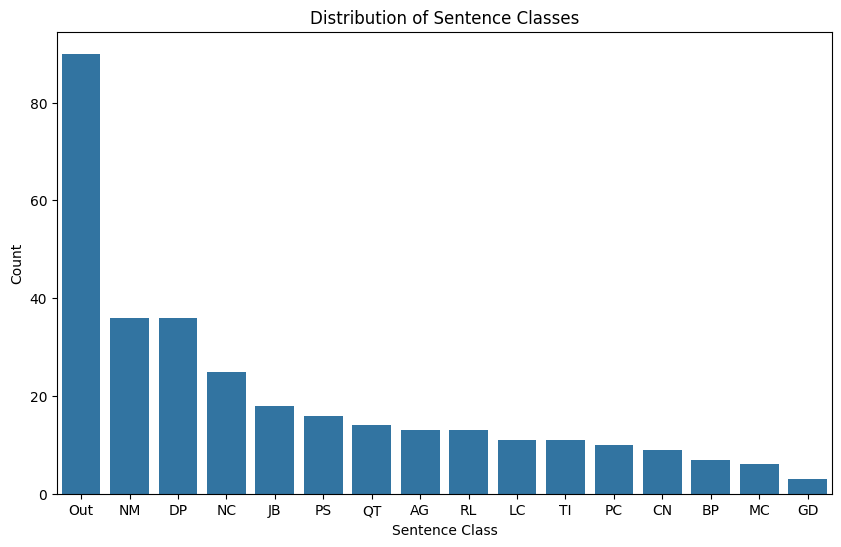

In [22]:
plot_chart(data)

In [23]:
# train, test = train_test_split(data, test_size=config.test_size, stratify=data['sentence_class'])
train, test = train_test_split(data, test_size=config.test_size)
print(f"|train| {train.shape[0]} / |test| {test.shape[0]} / before dropping O sentences")
'''
train, test:
train_test_split 함수는 데이터를 나눈 후, 결과를 두 개의 변수에 반환합니다. 첫 번째 변수인 train에는 훈련 세트가 저장되고, 두 번째 변수인 test에는 테스트 세트가 저장됩니다.

train_test_split(data, ...):
data는 나눌 대상이 되는 전체 데이터셋입니다. 이 데이터셋이 train과 test로 분리됩니다.

test_size=config.test_size:
테스트 세트의 크기를 지정하는 인수입니다. config.test_size는 테스트 세트의 비율 또는 절대 크기를 지정하는 값입니다.
예를 들어, config.test_size가 0.2라면, 전체 데이터의 20%가 테스트 세트로 할당되고, 나머지 80%는 훈련 세트로 할당됩니다. 이 값은 데이터셋의 크기에 따라 비율로 계산됩니다.

stratify=data['sentence_class']:
데이터셋을 분리할 때 sentence_class 열을 기준으로 계층화(stratify)하여 샘플링합니다.
계층화 샘플링을 사용하면 sentence_class 열에 존재하는 각 클래스의 비율이 훈련 세트와 테스트 세트에 동일하게 유지되도록 데이터가 나뉩니다. 즉, 클래스 불균형이 있는 데이터셋에서 훈련 세트와 테스트 세트 모두에서 클래스 비율을 유지하게 됩니다.
'''

|train| 270 / |test| 48 / before dropping O sentences


"\ntrain, test:\ntrain_test_split 함수는 데이터를 나눈 후, 결과를 두 개의 변수에 반환합니다. 첫 번째 변수인 train에는 훈련 세트가 저장되고, 두 번째 변수인 test에는 테스트 세트가 저장됩니다.\n\ntrain_test_split(data, ...):\ndata는 나눌 대상이 되는 전체 데이터셋입니다. 이 데이터셋이 train과 test로 분리됩니다.\n\ntest_size=config.test_size:\n테스트 세트의 크기를 지정하는 인수입니다. config.test_size는 테스트 세트의 비율 또는 절대 크기를 지정하는 값입니다.\n예를 들어, config.test_size가 0.2라면, 전체 데이터의 20%가 테스트 세트로 할당되고, 나머지 80%는 훈련 세트로 할당됩니다. 이 값은 데이터셋의 크기에 따라 비율로 계산됩니다.\n\nstratify=data['sentence_class']:\n데이터셋을 분리할 때 sentence_class 열을 기준으로 계층화(stratify)하여 샘플링합니다.\n계층화 샘플링을 사용하면 sentence_class 열에 존재하는 각 클래스의 비율이 훈련 세트와 테스트 세트에 동일하게 유지되도록 데이터가 나뉩니다. 즉, 클래스 불균형이 있는 데이터셋에서 훈련 세트와 테스트 세트 모두에서 클래스 비율을 유지하게 됩니다.\n"

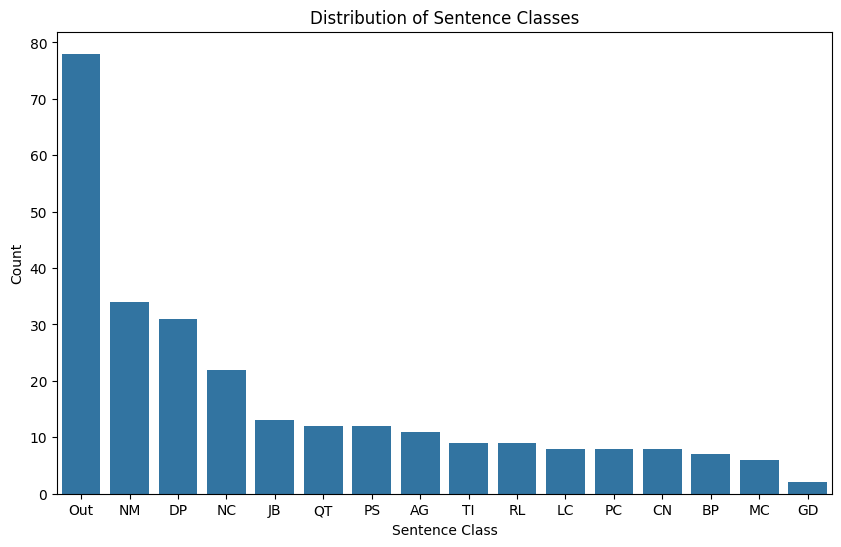

,sentence,ne,source,ne_label_list,sentence_class
146,"각 형법 제10조 제2항, 제1항, 제55조 제1항 제3호(심신미약자)","{1: {'form': '심신미약', 'label': 'MC', 'begin': 3...",None,[MC],MC
177,판사 서우람,"{1: {'form': '서우람', 'label': 'NM', 'begin': 3,...",None,[NM],NM
261,"형법 제40조, 제50조(특수도주죄와 상해죄 상호간, 형이 더 무거운 특수도주죄에 ...","{1: {'form': '특수도주죄', 'label': 'NC', 'begin': ...",None,"[NC, NC, NC]",NC
284,"(1) 다음과 같은 사정들에 비추어 피해자 김선희, 최수연의 각 진술은 그 신빙성이...","{1: {'form': '피해자', 'label': 'PS_VICTIM', 'beg...",None,"[PS, NM, NM]",NM
278,(2) 피고인이 당시 소지하고 있던 현금 11만 원은 2007. 7. 9. 배철수로...,"{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, QT, TI, NM, QT, PS]",QT
...,...,...,...,...,...
139,법령의 적용,{},None,[],Out
31,"형법 제53조, 제55조 제1항 제3호 (아래 양형이유 중 유리한 정상 참작)",{},None,[],Out
260,1. 상상적 경합,"{1: {'form': '상상적 경합', 'label': 'DP_CONCURRENC...",None,[DP],DP
136,"1. 수사보고(증거목록 제8번, 제10번, 제11번, 제15번, 제22번, 제24번...",{},None,[],Out


In [24]:
plot_chart(train)
train

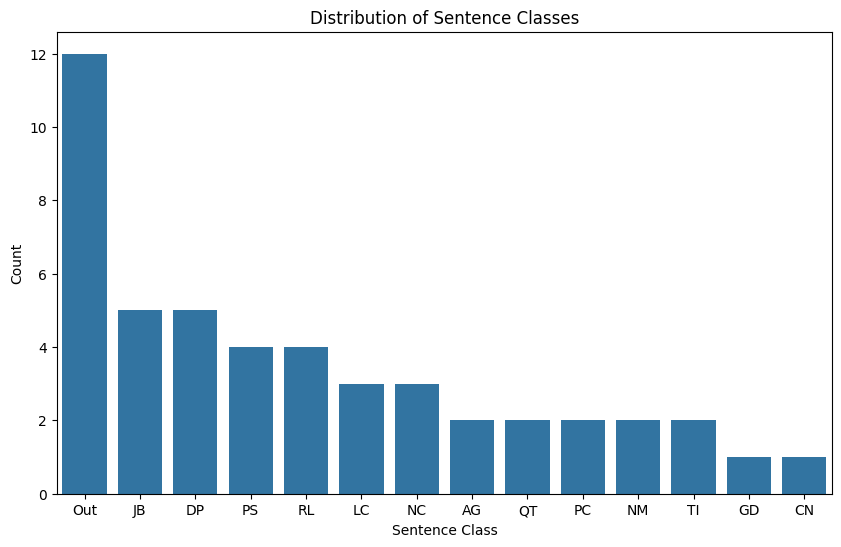

,sentence,ne,source,ne_label_list,sentence_class
45,본적 경북 의성군 의성읍 경북대로 5690-25,"{1: {'form': '본적', 'label': 'LC_DOMICILE', 'be...",None,"[LC, LC]",LC
172,한적한 길을 지나가는 여아를 상대로 나일론 줄로 목을 졸라 실신시킨 후 성추행을 하...,"{1: {'form': '길', 'label': 'LC_OTHER_FACILITY'...",None,"[LC, GD, EQ, BP, PC, NC, RL, RL, JB, LC, LC, N...",GD
192,피고인은 위 경찰관들이 위 정우식의 모발 채취를 하지 못하도록 하기 위하여 위 정우...,"{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, JB, NM, BP, NM, NM, BP, NM, BP, NM, NM]",JB
210,이 사건 당일 필로폰 투약 혐의로 수사를 받고 있던 친구인 정우식의 도주(모발 검사...,"{1: {'form': '당일', 'label': 'TI_SUBSTITUTE', '...",None,"[TI, RL, NM, BP, JB, QT, NC, JB]",QT
107,주거 대구 달성군 가창면 가창로 169,"{1: {'form': '주거', 'label': 'LC_RESIDENCE', 'b...",None,"[LC, LC]",LC
156,"나. 판시 제6항 기재 범행에 관하여, 피고인이 피해자 지화연의 목을 조르자 피해자...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, PS, NM, BP, PS, PC, PS, PS, LC, NM, BP, BP]",PC
303,"이러한 사정도 임조은이 피고인과 합의하에 성관계를 맺었다면 있을 수 없는 것인 점,...","{1: {'form': '임조은', 'label': 'NM', 'begin': 8,...",None,"[NM, PS, PS, NM, RL, RL, RL, NM, NM, PS]",RL
62,원심의 증거조사 결과와 항소심 변론종결시까지 추가로 이루어진 증거조사 결과를 종합하...,"{1: {'form': '증인', 'label': 'PS_OTHERS', 'begi...",None,[PS],PS
212,이러한 행위는 통상적으로 빈번하게 일어나고 있는 공무집행방해의 형태 즉 술에 취해 ...,"{1: {'form': '공무집행방해', 'label': 'NC', 'begin':...",None,"[NC, NC, DP]",DP
208,양형의 이유,{},None,[],Out


In [25]:
plot_chart(test)
test

In [26]:
# Drop "O" sentences and add some sample for test
if config.pass_drop_o:
    pass
else:
    train = train[train['ne_label_list'].map(len) > 0] # 훈련 데이터에서 ne_label_list의 길이가 0보다 큰 데이터만 남깁니다. 즉, NE 레이블이 하나라도 있는 문장만 유지합니다.
    test_o = test[test['ne_label_list'].map(len) == 0] # 테스트 데이터에서도 NE 레이블이 없는 문장은 test_o에 저장합니다.
    test = test[test['ne_label_list'].map(len) > 0] # 그리고 훈련 데이터에서와 마찬가지로 레이블이 없는 문장은 모두 지웁니다.

    
    if config.test_o_size > 0: # config.test_o_size가 0보다 크면, "O" 문장을 일정 비율로 테스트 데이터에 추가합니다. 이는 다양성을 높이고, 모델이 "O" 문장을 어떻게 처리하는지 평가하기 위함입니다.
        test_o['n_words'] = test_o['sentence'].map(lambda x: len(x.split())) # test_o 데이터셋에서 각 문장의 단어 수를 계산하여 n_words 열을 추가합니다.
        test_o_from_n = test_o[test_o['source'] == 'N'] # 소스가 'N'인 "O" 문장과 'S'인 "O" 문장을 각각 분리합니다.
        test_o_from_s = test_o[test_o['source'] == 'S']

        test_o_ratio = config.test_o_size / (1 - config.test_o_size) # 설정된 비율에 따라 테스트 데이터셋에 포함할 "O" 문장의 총 수를 계산합니다.
        num_o_sample = int(test.shape[0] * test_o_ratio)
        num_o_from_n = min(num_o_sample // 2, test_o_from_n.shape[0])
        num_o_from_s = num_o_sample - num_o_from_n
        # 'N' 소스와 'S' 소스에서 가져올 "O" 문장 수를 계산합니다.

        test_o_from_n = test_o_from_n.sample(n=num_o_from_n, random_state=42)
        test_o_from_s = test_o_from_s.sample(n=num_o_from_s, weights='n_words', random_state=42) 
        # 'N' 소스와 'S' 소스에서 각각 계산된 수만큼 "O" 문장을 무작위로 선택합니다. 'S' 소스에서는 문장의 단어 수에 따라 가중치를 두고 샘플링합니다.
                       
        test = pd.concat([test, test_o_from_n, test_o_from_s])
        # 최종적으로, 기존의 테스트 데이터셋에 이 "O" 문장을 추가하여 하나의 테스트 데이터셋으로 병합합니다.

In [27]:
print(config.pass_drop_o)
print(config.test_o_size)
test

True
0


,sentence,ne,source,ne_label_list,sentence_class
45,본적 경북 의성군 의성읍 경북대로 5690-25,"{1: {'form': '본적', 'label': 'LC_DOMICILE', 'be...",None,"[LC, LC]",LC
172,한적한 길을 지나가는 여아를 상대로 나일론 줄로 목을 졸라 실신시킨 후 성추행을 하...,"{1: {'form': '길', 'label': 'LC_OTHER_FACILITY'...",None,"[LC, GD, EQ, BP, PC, NC, RL, RL, JB, LC, LC, N...",GD
192,피고인은 위 경찰관들이 위 정우식의 모발 채취를 하지 못하도록 하기 위하여 위 정우...,"{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, JB, NM, BP, NM, NM, BP, NM, BP, NM, NM]",JB
210,이 사건 당일 필로폰 투약 혐의로 수사를 받고 있던 친구인 정우식의 도주(모발 검사...,"{1: {'form': '당일', 'label': 'TI_SUBSTITUTE', '...",None,"[TI, RL, NM, BP, JB, QT, NC, JB]",QT
107,주거 대구 달성군 가창면 가창로 169,"{1: {'form': '주거', 'label': 'LC_RESIDENCE', 'b...",None,"[LC, LC]",LC
156,"나. 판시 제6항 기재 범행에 관하여, 피고인이 피해자 지화연의 목을 조르자 피해자...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, PS, NM, BP, PS, PC, PS, PS, LC, NM, BP, BP]",PC
303,"이러한 사정도 임조은이 피고인과 합의하에 성관계를 맺었다면 있을 수 없는 것인 점,...","{1: {'form': '임조은', 'label': 'NM', 'begin': 8,...",None,"[NM, PS, PS, NM, RL, RL, RL, NM, NM, PS]",RL
62,원심의 증거조사 결과와 항소심 변론종결시까지 추가로 이루어진 증거조사 결과를 종합하...,"{1: {'form': '증인', 'label': 'PS_OTHERS', 'begi...",None,[PS],PS
212,이러한 행위는 통상적으로 빈번하게 일어나고 있는 공무집행방해의 형태 즉 술에 취해 ...,"{1: {'form': '공무집행방해', 'label': 'NC', 'begin':...",None,"[NC, NC, DP]",DP
208,양형의 이유,{},None,[],Out


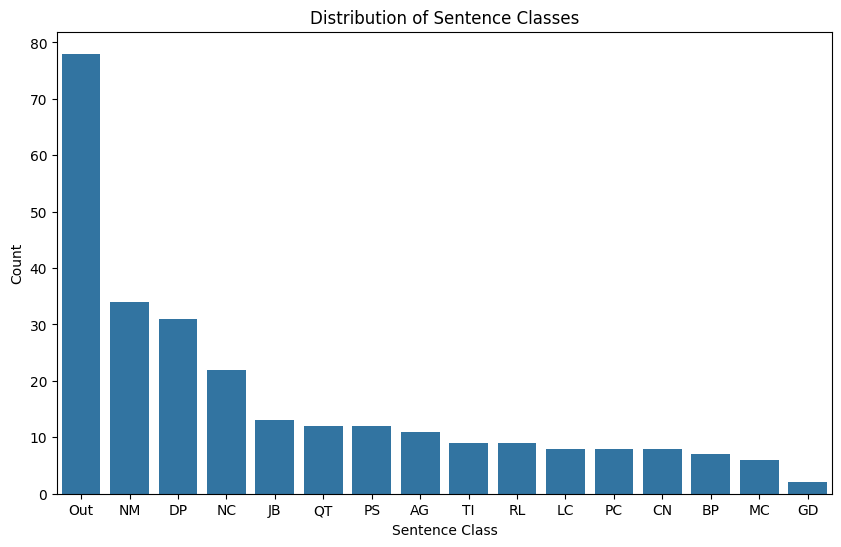

,sentence,ne,source,ne_label_list,sentence_class
146,"각 형법 제10조 제2항, 제1항, 제55조 제1항 제3호(심신미약자)","{1: {'form': '심신미약', 'label': 'MC', 'begin': 3...",None,[MC],MC
177,판사 서우람,"{1: {'form': '서우람', 'label': 'NM', 'begin': 3,...",None,[NM],NM
261,"형법 제40조, 제50조(특수도주죄와 상해죄 상호간, 형이 더 무거운 특수도주죄에 ...","{1: {'form': '특수도주죄', 'label': 'NC', 'begin': ...",None,"[NC, NC, NC]",NC
284,"(1) 다음과 같은 사정들에 비추어 피해자 김선희, 최수연의 각 진술은 그 신빙성이...","{1: {'form': '피해자', 'label': 'PS_VICTIM', 'beg...",None,"[PS, NM, NM]",NM
278,(2) 피고인이 당시 소지하고 있던 현금 11만 원은 2007. 7. 9. 배철수로...,"{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, QT, TI, NM, QT, PS]",QT
...,...,...,...,...,...
139,법령의 적용,{},None,[],Out
31,"형법 제53조, 제55조 제1항 제3호 (아래 양형이유 중 유리한 정상 참작)",{},None,[],Out
260,1. 상상적 경합,"{1: {'form': '상상적 경합', 'label': 'DP_CONCURRENC...",None,[DP],DP
136,"1. 수사보고(증거목록 제8번, 제10번, 제11번, 제15번, 제22번, 제24번...",{},None,[],Out


In [28]:
plot_chart(train)
train

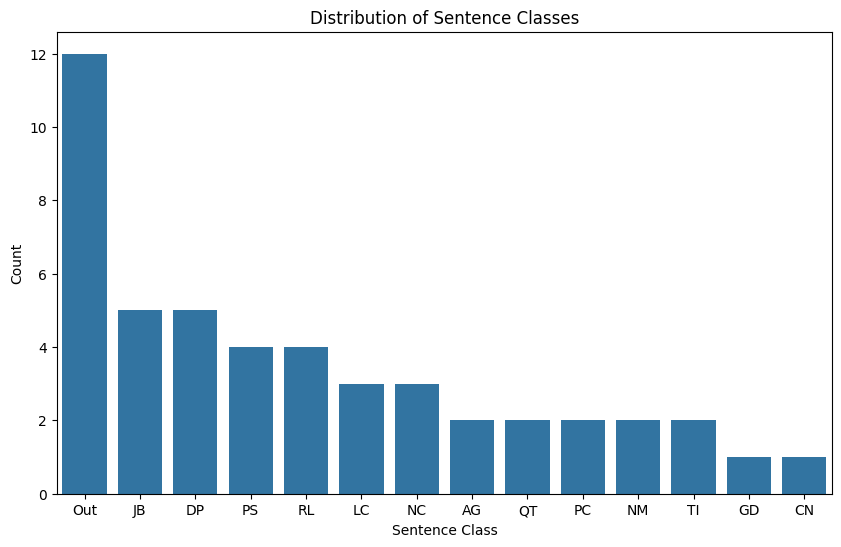

,sentence,ne,source,ne_label_list,sentence_class
45,본적 경북 의성군 의성읍 경북대로 5690-25,"{1: {'form': '본적', 'label': 'LC_DOMICILE', 'be...",None,"[LC, LC]",LC
172,한적한 길을 지나가는 여아를 상대로 나일론 줄로 목을 졸라 실신시킨 후 성추행을 하...,"{1: {'form': '길', 'label': 'LC_OTHER_FACILITY'...",None,"[LC, GD, EQ, BP, PC, NC, RL, RL, JB, LC, LC, N...",GD
192,피고인은 위 경찰관들이 위 정우식의 모발 채취를 하지 못하도록 하기 위하여 위 정우...,"{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, JB, NM, BP, NM, NM, BP, NM, BP, NM, NM]",JB
210,이 사건 당일 필로폰 투약 혐의로 수사를 받고 있던 친구인 정우식의 도주(모발 검사...,"{1: {'form': '당일', 'label': 'TI_SUBSTITUTE', '...",None,"[TI, RL, NM, BP, JB, QT, NC, JB]",QT
107,주거 대구 달성군 가창면 가창로 169,"{1: {'form': '주거', 'label': 'LC_RESIDENCE', 'b...",None,"[LC, LC]",LC
156,"나. 판시 제6항 기재 범행에 관하여, 피고인이 피해자 지화연의 목을 조르자 피해자...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, PS, NM, BP, PS, PC, PS, PS, LC, NM, BP, BP]",PC
303,"이러한 사정도 임조은이 피고인과 합의하에 성관계를 맺었다면 있을 수 없는 것인 점,...","{1: {'form': '임조은', 'label': 'NM', 'begin': 8,...",None,"[NM, PS, PS, NM, RL, RL, RL, NM, NM, PS]",RL
62,원심의 증거조사 결과와 항소심 변론종결시까지 추가로 이루어진 증거조사 결과를 종합하...,"{1: {'form': '증인', 'label': 'PS_OTHERS', 'begi...",None,[PS],PS
212,이러한 행위는 통상적으로 빈번하게 일어나고 있는 공무집행방해의 형태 즉 술에 취해 ...,"{1: {'form': '공무집행방해', 'label': 'NC', 'begin':...",None,"[NC, NC, DP]",DP
208,양형의 이유,{},None,[],Out


In [29]:
plot_chart(test)
test

In [30]:
data

,sentence,ne,source,ne_label_list,sentence_class
0,대구지방법원 2007. 11. 1 선고 2007고합91 판결 [특정범죄 가중처벌 등...,"{1: {'form': '2007. 11. 1', 'label': 'TI_DATE'...",None,"[TI, CN, NC]",CN
1,참조조문,{},None,[],Out
2,"특정범죄 가중처벌 등에 관한 법률 제5조의10 제2항전단, 제1항",{},None,[],Out
3,전 문,{},None,[],Out
4,"피고인 전수환 (628756-1249682), 노동","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, NM, JB]",JB
...,...,...,...,...,...
313,"한편 피고인은 어린 시절 특수강도죄 등으로 수차례 보호처분을 받은 전력이 있고, 2...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, NC, QT, DP, TI, NC, DP, TI, TI, TI, TI, N...",QT
314,그 후 2007. 1. 30. 가석방되어 2007. 5. 6. 그 잔형기가 경과되었...,"{1: {'form': '2007. 1. 30.', 'label': 'TI_DATE...",None,"[TI, TI, TI]",TI
315,"위와 같은 제반 정상을 모두 종합하여 보면, 피고인을 사회와 상당기간 격리하여 구금...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, DP]",DP
316,재판장 판사 백승현 판사 김빛나,"{1: {'form': '백승현', 'label': 'NM', 'begin': 7,...",None,"[NM, NM]",NM


In [31]:
train

,sentence,ne,source,ne_label_list,sentence_class
146,"각 형법 제10조 제2항, 제1항, 제55조 제1항 제3호(심신미약자)","{1: {'form': '심신미약', 'label': 'MC', 'begin': 3...",None,[MC],MC
177,판사 서우람,"{1: {'form': '서우람', 'label': 'NM', 'begin': 3,...",None,[NM],NM
261,"형법 제40조, 제50조(특수도주죄와 상해죄 상호간, 형이 더 무거운 특수도주죄에 ...","{1: {'form': '특수도주죄', 'label': 'NC', 'begin': ...",None,"[NC, NC, NC]",NC
284,"(1) 다음과 같은 사정들에 비추어 피해자 김선희, 최수연의 각 진술은 그 신빙성이...","{1: {'form': '피해자', 'label': 'PS_VICTIM', 'beg...",None,"[PS, NM, NM]",NM
278,(2) 피고인이 당시 소지하고 있던 현금 11만 원은 2007. 7. 9. 배철수로...,"{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, QT, TI, NM, QT, PS]",QT
...,...,...,...,...,...
139,법령의 적용,{},None,[],Out
31,"형법 제53조, 제55조 제1항 제3호 (아래 양형이유 중 유리한 정상 참작)",{},None,[],Out
260,1. 상상적 경합,"{1: {'form': '상상적 경합', 'label': 'DP_CONCURRENC...",None,[DP],DP
136,"1. 수사보고(증거목록 제8번, 제10번, 제11번, 제15번, 제22번, 제24번...",{},None,[],Out


In [32]:
test

,sentence,ne,source,ne_label_list,sentence_class
45,본적 경북 의성군 의성읍 경북대로 5690-25,"{1: {'form': '본적', 'label': 'LC_DOMICILE', 'be...",None,"[LC, LC]",LC
172,한적한 길을 지나가는 여아를 상대로 나일론 줄로 목을 졸라 실신시킨 후 성추행을 하...,"{1: {'form': '길', 'label': 'LC_OTHER_FACILITY'...",None,"[LC, GD, EQ, BP, PC, NC, RL, RL, JB, LC, LC, N...",GD
192,피고인은 위 경찰관들이 위 정우식의 모발 채취를 하지 못하도록 하기 위하여 위 정우...,"{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, JB, NM, BP, NM, NM, BP, NM, BP, NM, NM]",JB
210,이 사건 당일 필로폰 투약 혐의로 수사를 받고 있던 친구인 정우식의 도주(모발 검사...,"{1: {'form': '당일', 'label': 'TI_SUBSTITUTE', '...",None,"[TI, RL, NM, BP, JB, QT, NC, JB]",QT
107,주거 대구 달성군 가창면 가창로 169,"{1: {'form': '주거', 'label': 'LC_RESIDENCE', 'b...",None,"[LC, LC]",LC
156,"나. 판시 제6항 기재 범행에 관하여, 피고인이 피해자 지화연의 목을 조르자 피해자...","{1: {'form': '피고인', 'label': 'PS_ASSAILANT', '...",None,"[PS, PS, NM, BP, PS, PC, PS, PS, LC, NM, BP, BP]",PC
303,"이러한 사정도 임조은이 피고인과 합의하에 성관계를 맺었다면 있을 수 없는 것인 점,...","{1: {'form': '임조은', 'label': 'NM', 'begin': 8,...",None,"[NM, PS, PS, NM, RL, RL, RL, NM, NM, PS]",RL
62,원심의 증거조사 결과와 항소심 변론종결시까지 추가로 이루어진 증거조사 결과를 종합하...,"{1: {'form': '증인', 'label': 'PS_OTHERS', 'begi...",None,[PS],PS
212,이러한 행위는 통상적으로 빈번하게 일어나고 있는 공무집행방해의 형태 즉 술에 취해 ...,"{1: {'form': '공무집행방해', 'label': 'NC', 'begin':...",None,"[NC, NC, DP]",DP
208,양형의 이유,{},None,[],Out


In [33]:
data = data.drop(columns=["ne_label_list"])
train = train.drop(columns=["ne_label_list"])
test = test.drop(columns=["ne_label_list"])

if config.test_o_size > 0:
    test = test.drop(columns=["n_words"])

print(f"|train| {train.shape[0]} / |test| {test.shape[0]} / after dropping and sampling O sentences")

|train| 270 / |test| 48 / after dropping and sampling O sentences


In [34]:
if config.save_all:
    data.to_pickle(os.path.join(save_path, 'data.pickle'))

train.to_pickle(os.path.join(save_path, 'train.pickle'))
test.to_pickle(os.path.join(save_path, 'test.pickle'))

In [35]:
if config.return_tsv:
    if config.save_all:
        data.to_csv(os.path.join(save_path, 'data.tsv'), sep='\t', index=False)
    train.to_csv(os.path.join(save_path, 'train.tsv'), sep='\t', index=False)
    test.to_csv(os.path.join(save_path, 'test.tsv'), sep='\t', index=False)